In [1]:
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf

https://personal.math.ubc.ca/%7Ecbm/aands/page_299.htm by Abramowitz and Stegran p. 299 gives an approximation to the error function with approximation error |eps(x)|<= 3*10^(-7) for x in [0,infinity)]

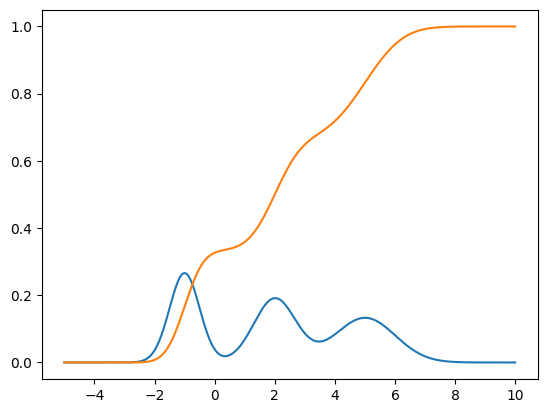

In [2]:


g = lambda x, m, s: np.exp(-0.5*((x-m)/s)**2) / (s*np.sqrt(2* np.pi)) # Normal PDF
f = lambda x, ms, ss: np.sum([g(x,ms[i],ss[i]) for i in range(len(ms))], axis=0) / len(ms) # Sum of multiple normal PDFs

def cumulative_normal_density_function_for_sum_of_normals(X: tf.Tensor, muhs: tf.Tensor, sigmas: tf.Tensor) -> tf.Tensor:
    """Computes the cumulative normal density for the sum of k normal distributions element-wise. Since no closed form exists for this operation,
    an approximation is used with an error margin of :math:`\pm 3*10^{-7}`.
    All tensors are assumed to have the same precision.

    :param X: A tensor containing input values to the density function.
    :type X: :class:`tensorflow.Tensor`
    :param muhs: A tensor collecting the means of the k normal distributions. Shape == [k].
    :type muhs: :class:`tensorflow.Tensor`
    :param sigmas: A tensor collecting the standard deviations of the k normal distributions. Indexing is assumed to be synchronous with `muhs`.
    :type sigmas: :class:`tensorflow.Tensor`

    :return: P (:class:'tensorflow.Tensor') - The cumulative probability values coresponding to `X`.

    References:

    - "Handbook of Mathematical Functions" by Abramowitz and Stegran, p. 299. Retrieved April 12, 2024 from https://personal.math.ubc.ca/%7Ecbm/aands/page_299.htm 
    """

    # Assumptions
    assert tf.is_tensor(X) and tf.is_tensor(muhs) and tf.is_tensor(sigmas), f"The inputs X, muhs and sigmas are all expected to be tensorflow.Tensor objects, but were found {type(X), type(muhs), type(sigmas)}, respectively."
    assert X.dtype == muhs.dtype and muhs.dtype == sigmas.dtype, f"The inputs X, muhs and sigmas are expected to have the same data type but were found to have {X.dtype, muhs.dtype, sigmas.dtype}, respectively."

    # Error function (approximated)
    def erf(X):
        Y = tf.zeros_like(X)
        X_l = np.zeros(X.shape); X_l[np.where(X<=0)] = 1; X_l = tf.constant(X_l, dtype=X.dtype) # Mask selecting the non-poitive X values
        X_u = np.zeros(X.shape); X_u[np.where(0< X)] = 1; X_u = tf.constant(X_u, dtype=X.dtype) # Mask selecting the positive X values
        
        Y += X_l* -tf.math.erf(-X)#(1/(1-0.0705230784*X + 0.0422820123*X**2 - 0.0092705272*X**3 + 0.0001520143*X**4 - 0.0002765672*X**5 + 0.0000430638*X**6)**16 - 1)
        Y += X_u* tf.math.erf(X)#(1-1/(1+0.0705230784*X + 0.0422820123*X**2 + 0.0092705272*X**3 + 0.0001520143*X**4 + 0.0002765672*X**5 + 0.0000430638*X**6)**16)
        
        return Y

    # Normal CDF (aproximated)
    G = lambda X, m, s: 0.5*(1+erf((X-m)/(s*np.sqrt(2))))

    # Compute cumulative density
    P = tf.reduce_sum([G(X, muhs[i],sigmas[i]) for i in range(len(muhs))], axis=0) / len(muhs)

    # Outputs
    return P

x = tf.range(-5,10,0.01)
ms = tf.constant([-1,2,5.0])
ss = tf.constant([0.5,0.7,1])

plt.figure()
plt.plot(x,f(x.numpy(),ms,ss))
plt.plot(x,cumulative_normal_density_function_for_sum_of_normals(x,ms,ss))
plt.show()

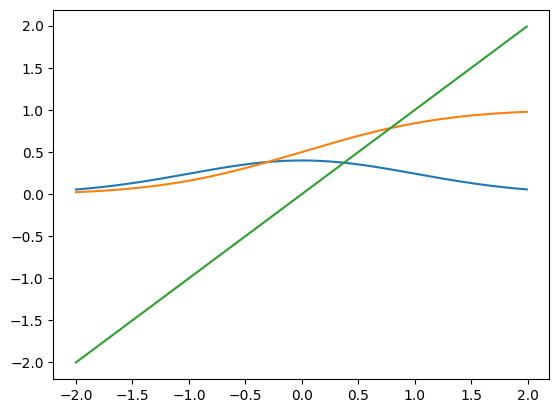

In [5]:
def inverse_normal_cumulative_density_function(P) -> tf.Tensor:
    """This function applies the inverse nornal cumulative density (also known as quantile function) element-wise to the input ``P``. Since no closed form
    of this operation exists it is hereby approximated up to an error margin of :math:`\pm 1.15 \times 10^{-9}` over th eentire region. 
    
    :param P: A tensor of probability values, i.e. values in the range [0,1].
    :type P: :class:`tensorflow.Tensor`
    :return: X_hat (:class:`tensorflow.Tensor`) - The approximated x values that are associated with the corresponding P values of the cumulative normal density function. Shape == `P`.shape.

    References:

        - `https://web.archive.org/web/20151030215612/http://home.online.no/~pjacklam/notes/invnorm/#Error_plots`_
        - `https://stackedboxes.org/2017/05/01/acklams-normal-quantile-function/`"""

    # Coefficients in rational approximations.
    a = [-3.969683028665376e+01, 2.209460984245205e+02, -2.759285104469687e+02,  1.383577518672690e+02, -3.066479806614716e+01,  2.506628277459239e+00]
    b = [-5.447609879822406e+01, 1.615858368580409e+02, -1.556989798598866e+02, 6.680131188771972e+01, -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01, -2.400758277161838e+00, -2.549732539343734e+00, 4.374664141464968e+00, 2.938163982698783e+00]
    d = [7.784695709041462e-03, 3.224671290700398e-01, 2.445134137142996e+00, 3.754408661907416e+00]

    # Initialize output
    X_hat = tf.zeros_like(P)

    # The approximation is piece-wise, hence define interval steps.
    p_low  = 0.02425
    p_high = 1 - p_low

    # Rational approximation for lower region.
    P_below_low = np.zeros(P.shape); P_below_low[np.where(P<p_low)] = 1; P_below_low = tf.constant(P_below_low, dtype=P.dtype) # Mask that selects p < p_low
    Q = tf.math.sqrt(-2*tf.math.log(P))
    X_hat += P_below_low * (((((c[0]*Q+c[1])*Q+c[2])*Q+c[3])*Q+c[4])*Q+c[5]) / ((((d[0]*Q+d[1])*Q+d[2])*Q+d[3])*Q+1)

    # Rational approximation for central region.
    P_center = np.zeros(P.shape); P_center[np.logical_and(p_low <= P, P <= p_high)] = 1; P_center = tf.constant(P_center, dtype=P.dtype) # Masks that selects p between p_low and p_high
    Q = (P - 0.5); R = Q**2
    X_hat += P_center * (((((a[0]*R+a[1])*R+a[2])*R+a[3])*R+a[4])*R+a[5])*Q / (((((b[0]*R+b[1])*R+b[2])*R+b[3])*R+b[4])*R+1)

    # Rational approximation for upper region.
    P_above_high = np.zeros(P.shape); P_above_high[np.where(p_high < P)] = 1; tf.constant(P_above_high, dtype=P.dtype) # Masks that selects p above p_high
    Q = tf.math.sqrt(-2*tf.math.log(1-P))
    X_hat += P_above_high * (-(((((c[0]*Q+c[1])*Q+c[2])*Q+c[3])*Q+c[4])*Q+c[5]) / ((((d[0]*Q+d[1])*Q+d[2])*Q+d[3])*Q+1))
    
    # Outputs
    return X_hat

import tensorflow_probability as tfp
def sum_of_normals_to_single_normal(X: tf.Tensor, muhs: tf.Tensor, sigmas: tf.Tensor) -> tf.Tensor:
    
    # Apply universality of uniform theorem
    P = cumulative_normal_density_function_for_sum_of_normals(X=X, muhs=muhs, sigmas=sigmas) # Transform distribution to standard uniform
    Z = tfp.distributions.Normal(loc=tf.constant(0.0, dtype='double'), scale=tf.constant(1.0, dtype='double')).quantile(P) #inverse_normal_cumulative_density_function(P=P) # Transform distribution to standard normal

    # Outputs
    return Z


x = tf.range(-2,2,0.01)
m,s = 0.0, 1.0

plt.figure()
plt.plot(x, g(x,m,s))
p = cumulative_normal_density_function_for_sum_of_normals(x,tf.constant([m]), tf.constant([s]))
plt.plot(x, p)
plt.plot(x, inverse_normal_cumulative_density_function(tf.constant(p)).numpy())
plt.show()


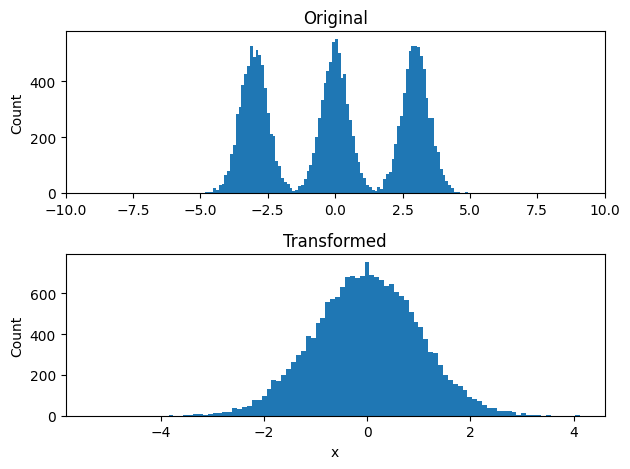

In [8]:
def sample(x_min, x_max, n, f):
    x = np.random.uniform(low=x_min, high=x_max, size=n)
    y = np.random.uniform(low=0, high=np.max(f(x)), size=n)

    return x[np.where(y <= f(x))]
muhs = tf.constant([-3,0,3], dtype='double'); sigmas = tf.constant([0.5,0.5,0.5], dtype='double')
x = tf.constant(sample(-100,100,1000000, lambda x: f(x,muhs,sigmas)), dtype='double')


plt.figure(); 
plt.subplot(2,1,1); plt.title("Original")
plt.hist(x, bins=100); plt.xlim(-10,10); plt.ylabel("Count")
plt.subplot(2,1,2); plt.title("Transformed")
plt.hist(sum_of_normals_to_single_normal(X=x, muhs=muhs, sigmas=sigmas), bins=100); plt.ylabel("Count"); plt.xlabel("x"); plt.tight_layout()